In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
import librosa
from collections import Counter

DATA_DIR = 'voice-icar-federico-ii-database-1.0.0'
FS = 8000

def nacti_zaznam(cislo):
    jmeno = f'voice{cislo:03d}'
    cesta = os.path.join(DATA_DIR, jmeno)
    rec = wfdb.rdrecord(cesta)
    sig = rec.p_signal[:, 0]
    
    info = {}
    with open(os.path.join(DATA_DIR, f'{jmeno}-info.txt'), 'r') as f:
        for radek in f:
            if ':' in radek:
                klic, hodnota = radek.split(':', 1)
                info[klic.strip()] = hodnota.strip()
    
    diagnoza = info.get('Diagnosis', 'unknown')
    stav = 'healthy' if diagnoza == 'healthy' else 'pathological'
    
    return {'id': jmeno, 'signal': sig, 'diagnoza': diagnoza, 'stav': stav}

zaznamy = []
for i in range(1, 209):
    try:
        zaznamy.append(nacti_zaznam(i))
    except:
        pass

print(f'Nacteno {len(zaznamy)} zaznamu')
print(f'Zdravych: {sum(1 for z in zaznamy if z["stav"] == "healthy")}')
print(f'Patologickych: {sum(1 for z in zaznamy if z["stav"] == "pathological")}')
print(f'\nDiagnozy:')
for d, n in Counter(z['diagnoza'] for z in zaznamy).most_common():
    print(f'  {d}: {n}')

Nacteno 208 zaznamu
Zdravych: 57
Patologickych: 151

Diagnozy:
  healthy: 57
  hyperkinetic dysphonia: 43
  reflux laryngitis: 38
  hypokinetic dysphonia: 22
  hyperkinetic dysphonia (Prolapse): 9
  hypokinetic dysphonia (glottic insufficiency): 6
  hyperkinetic dysphonia (Polyps): 5
  hypokinetic dysphonia (Vocal fold paralysis): 4
  hyperkinetic dysphonia (nodule): 3
  hyperkinetic dysphonia (Reinke's edema): 3
  hyperkinetic dysphonia (Nodule): 2
  hyperkinetic dysphonia (Cordite): 1
  hypokinetic dysphonia (Spasmodic dysphonia): 1
  hypokinetic dysphonia (Conversion dysphonia): 1
  hyperkinetic dysphonia (Vocal fold prolapse): 1
  hypokinetic dysphonia (Dysphonia by chordal groove): 1
  hyperkinetic dysphonia (polyps): 1
  hypokinetic dysphonia (Laryngitis): 1
  hypokinetic dysphonia (Bilateral vocal fold): 1
  hyperkinetic dysphonia  (Rigid vocal fold): 1
  hypokinetic dysphonia (Extraglottic air leak): 1
  hyperkinetic dysphonia (Adduction deficit): 1
  hypokinetic dysphonia (Pre

## Zobrazení signálů

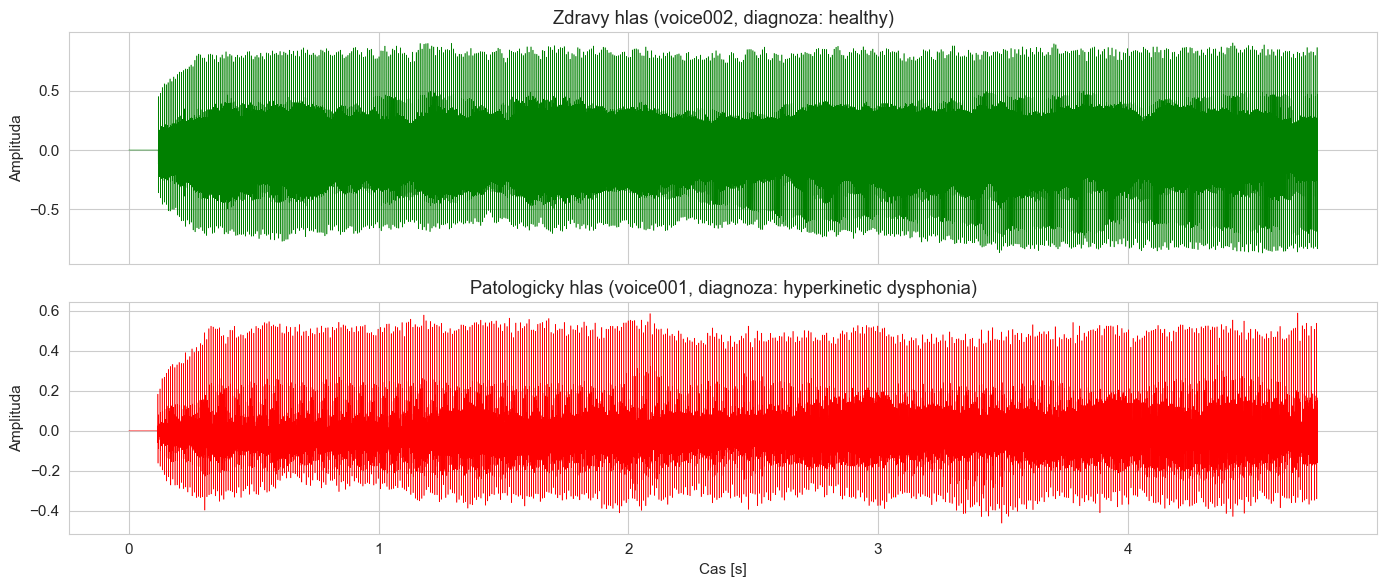

In [ ]:
idx_zdravy = next(i for i, z in enumerate(zaznamy) if z['stav'] == 'healthy')
idx_patol = next(i for i, z in enumerate(zaznamy) if z['stav'] == 'pathological')

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

for ax, idx, barva, titulek in [
    (axes[0], idx_zdravy, 'green', 'Zdravy hlas'),
    (axes[1], idx_patol, 'red', 'Patologicky hlas')
]:
    z = zaznamy[idx]
    cas = np.arange(len(z['signal'])) / FS
    ax.plot(cas, z['signal'], color=barva, linewidth=0.4)
    ax.set_title(f'{titulek} ({z["id"]}, diagnoza: {z["diagnoza"]})')
    ax.set_ylabel('Amplituda')

axes[1].set_xlabel('Cas [s]')
plt.tight_layout()
plt.show()

## Spektrální analýza (Fourierova transformace)


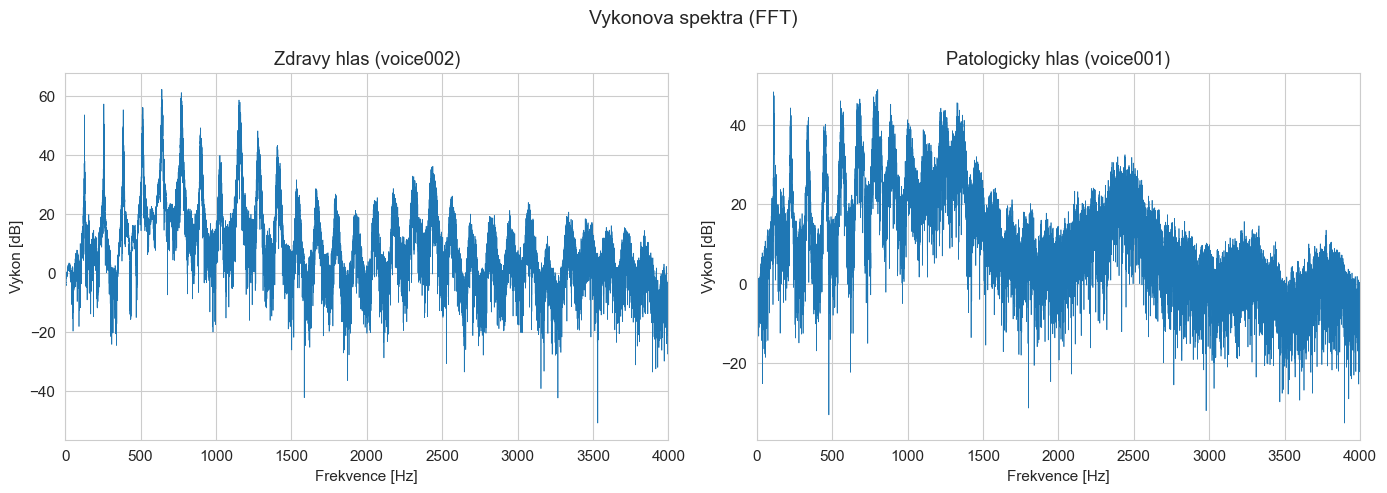

Spektralni centroid:
  Zdravi:       824.4 Hz
  Patologicti:  815.3 Hz


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, idx, titulek in [(axes[0], idx_zdravy, 'Zdravy hlas'), (axes[1], idx_patol, 'Patologicky hlas')]:
    sig = zaznamy[idx]['signal']
    n = len(sig)
    frekvence = np.fft.rfftfreq(n, 1/FS)
    spektrum = np.abs(np.fft.rfft(sig))
    psd_db = 20 * np.log10(spektrum + 1e-10)
    
    ax.plot(frekvence, psd_db, linewidth=0.5)
    ax.set_title(f'{titulek} ({zaznamy[idx]["id"]})')
    ax.set_xlabel('Frekvence [Hz]')
    ax.set_ylabel('Vykon [dB]')
    ax.set_xlim(0, 4000)

plt.suptitle('Vykonova spektra (FFT)', fontsize=14)
plt.tight_layout()
plt.show()

for z in zaznamy:
    sig = z['signal']
    frekvence = np.fft.rfftfreq(len(sig), 1/FS)
    spektrum = np.abs(np.fft.rfft(sig))**2
    
    z['spektr_centroid'] = np.sum(frekvence * spektrum) / (np.sum(spektrum) + 1e-10)

print('Spektralni centroid:')
print(f'  Zdravi:       {np.mean([z["spektr_centroid"] for z in zaznamy if z["stav"] == "healthy"]):.1f} Hz')
print(f'  Patologicti:  {np.mean([z["spektr_centroid"] for z in zaznamy if z["stav"] == "pathological"]):.1f} Hz')

## Harmonický šum (HNR)

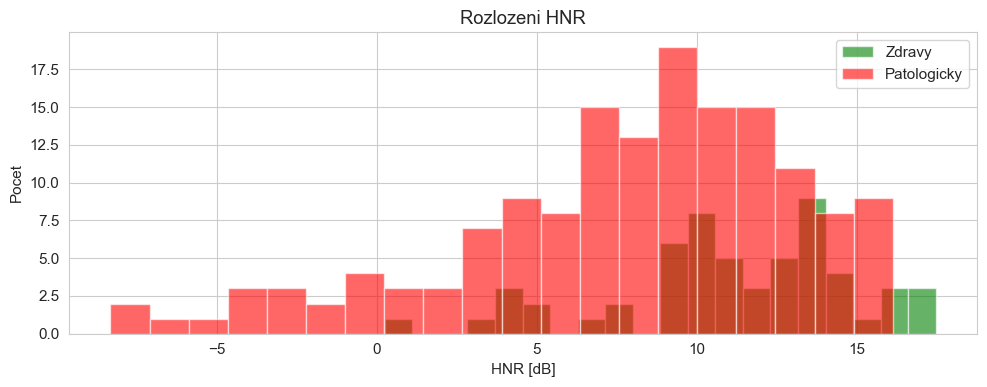

HNR:
  Zdravi:       11.09 dB
  Patologicti:  7.87 dB


In [ ]:
def vypocti_hnr(sig, fs):
    n = len(sig)
    korelace = np.correlate(sig, sig, mode='full')
    korelace = korelace[n-1:]
    korelace = korelace / (korelace[0] + 1e-10)
    
    min_lag = int(fs / 500)
    max_lag = min(int(fs / 50), len(korelace) - 1)
    
    usek = korelace[min_lag:max_lag]
    if len(usek) == 0:
        return 0.0
    
    peak = np.max(usek)
    if peak <= 0 or peak >= 1:
        return 0.0
    
    return 10 * np.log10(peak / (1 - peak + 1e-10))

for z in zaznamy:
    z['hnr'] = vypocti_hnr(z['signal'], FS)

hnr_zdravy = [z['hnr'] for z in zaznamy if z['stav'] == 'healthy']
hnr_patol = [z['hnr'] for z in zaznamy if z['stav'] == 'pathological']

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(hnr_zdravy, bins=20, alpha=0.6, label='Zdravy', color='green')
ax.hist(hnr_patol, bins=20, alpha=0.6, label='Patologicky', color='red')
ax.set_xlabel('HNR [dB]')
ax.set_ylabel('Pocet')
ax.set_title('Rozlozeni HNR')
ax.legend()
plt.tight_layout()
plt.show()

print(f'HNR:')
print(f'  Zdravi:       {np.mean(hnr_zdravy):.2f} dB')
print(f'  Patologicti:  {np.mean(hnr_patol):.2f} dB')

## Kepstrální analýza (MFCC)

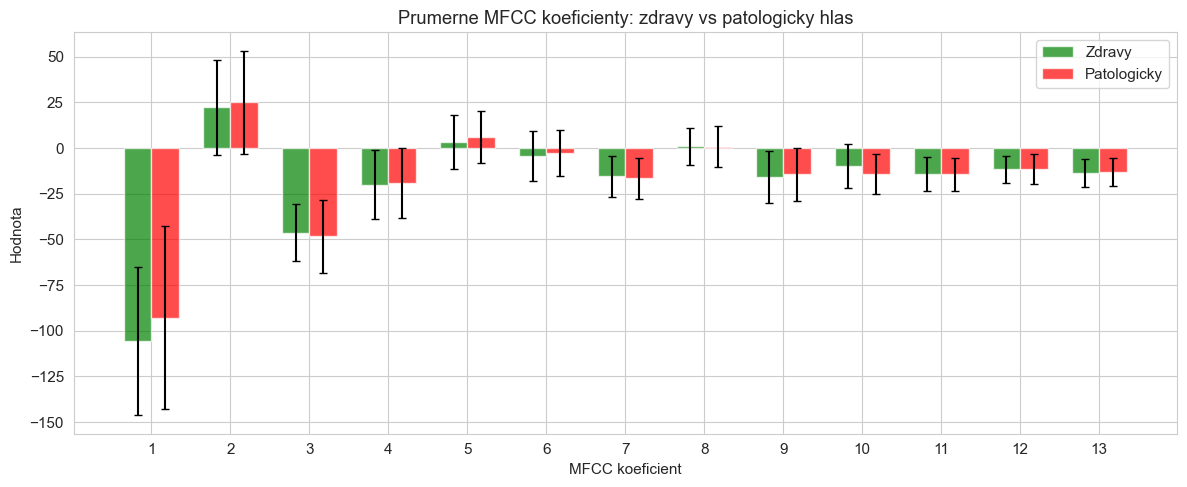

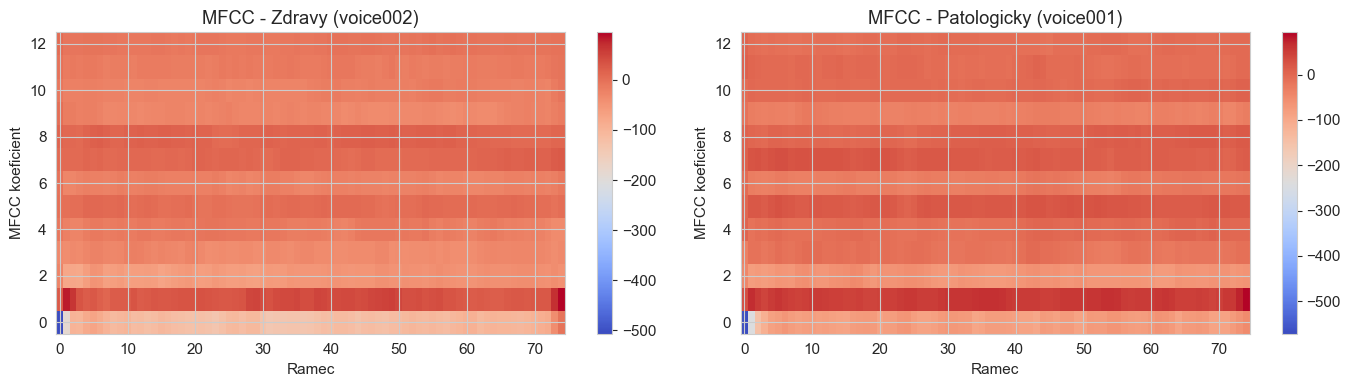

In [37]:
N_MFCC = 13

for z in zaznamy:
    mfcc = librosa.feature.mfcc(y=z['signal'].astype(float), sr=FS, n_mfcc=N_MFCC)
    for i in range(N_MFCC):
        z[f'mfcc_{i+1}'] = np.mean(mfcc[i])

mfcc_zdravy = np.array([[z[f'mfcc_{i+1}'] for i in range(N_MFCC)] for z in zaznamy if z['stav'] == 'healthy'])
mfcc_patol = np.array([[z[f'mfcc_{i+1}'] for i in range(N_MFCC)] for z in zaznamy if z['stav'] == 'pathological'])

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(N_MFCC)
sirka = 0.35

ax.bar(x - sirka/2, np.mean(mfcc_zdravy, axis=0), sirka, 
       yerr=np.std(mfcc_zdravy, axis=0), label='Zdravy', color='green', alpha=0.7, capsize=3)
ax.bar(x + sirka/2, np.mean(mfcc_patol, axis=0), sirka, 
       yerr=np.std(mfcc_patol, axis=0), label='Patologicky', color='red', alpha=0.7, capsize=3)

ax.set_xlabel('MFCC koeficient')
ax.set_ylabel('Hodnota')
ax.set_title('Prumerne MFCC koeficienty: zdravy vs patologicky hlas')
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in range(N_MFCC)])
ax.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax, idx, titulek in [(axes[0], idx_zdravy, 'Zdravy'), (axes[1], idx_patol, 'Patologicky')]:
    mfcc = librosa.feature.mfcc(y=zaznamy[idx]['signal'].astype(float), sr=FS, n_mfcc=N_MFCC)
    img = ax.imshow(mfcc, aspect='auto', origin='lower', cmap='coolwarm')
    ax.set_title(f'MFCC - {titulek} ({zaznamy[idx]["id"]})')
    ax.set_xlabel('Ramec')
    ax.set_ylabel('MFCC koeficient')
    plt.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Kombinovaná klasifikace

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

nazvy_priznaku = ['spektr_centroid', 'hnr']
nazvy_priznaku += [f'mfcc_{i+1}' for i in range(N_MFCC)]

X = np.array([[z[p] for p in nazvy_priznaku] for z in zaznamy])
y = np.array([0 if z['stav'] == 'healthy' else 1 for z in zaznamy])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

clf_strom = DecisionTreeClassifier(random_state=42, max_depth=5)
skore_strom = cross_val_score(clf_strom, X, y, cv=cv, scoring='accuracy')

print('kombinovana klasifikace (vsechny priznaky):')
print(f'Rozhodovaci strom:  {skore_strom.mean():.1%} +/- {skore_strom.std():.1%}')

clf_strom.fit(X_norm, y)
clf_strom.fit(X, y)
y_pred = clf_strom.predict(X)
print(classification_report(y, y_pred, target_names=['Zdravy', 'Patologicky']))

kombinovana klasifikace (vsechny priznaky):
Rozhodovaci strom:  66.8% +/- 8.0%
              precision    recall  f1-score   support

      Zdravy       0.88      0.74      0.80        57
 Patologicky       0.91      0.96      0.93       151

    accuracy                           0.90       208
   macro avg       0.89      0.85      0.87       208
weighted avg       0.90      0.90      0.90       208



## Porovnání s anotacemi z DBcka

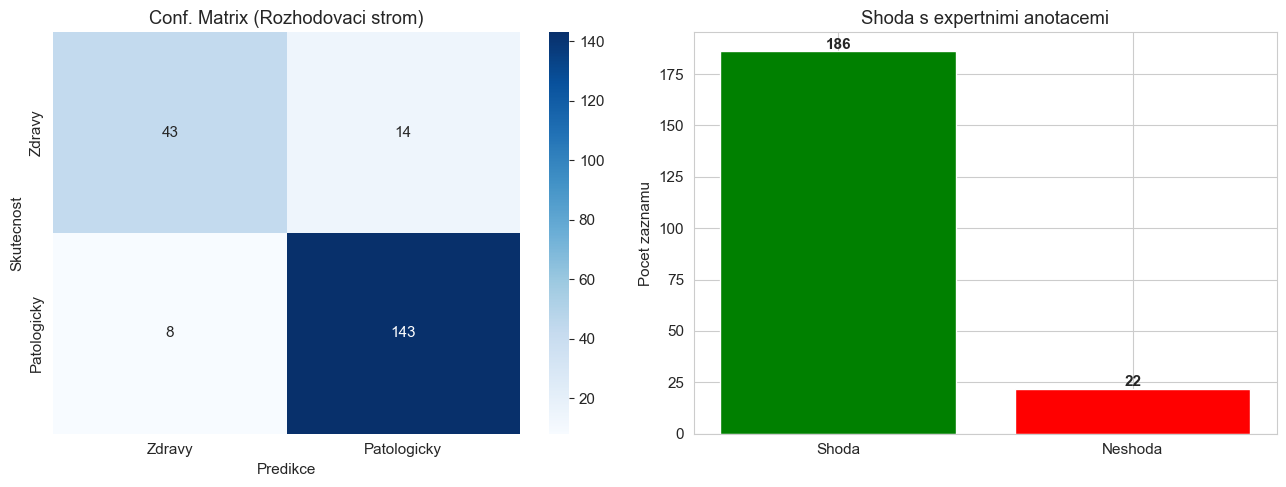

Celkova presnost: 186/208 (89.4%)

Zaznam       Skutecnost      Predikce        Vysledek  
voice001     Patologicky     Patologicky     SHODA     
voice002     Zdravy          Zdravy          SHODA     
voice003     Patologicky     Patologicky     SHODA     
voice004     Patologicky     Patologicky     SHODA     
voice005     Patologicky     Patologicky     SHODA     
voice006     Patologicky     Patologicky     SHODA     
voice007     Patologicky     Patologicky     SHODA     
voice008     Patologicky     Patologicky     SHODA     
voice009     Patologicky     Patologicky     SHODA     
voice010     Patologicky     Patologicky     SHODA     
voice011     Patologicky     Patologicky     SHODA     
voice012     Patologicky     Patologicky     SHODA     
voice013     Patologicky     Patologicky     SHODA     
voice014     Patologicky     Patologicky     SHODA     
voice015     Patologicky     Patologicky     SHODA     
voice016     Patologicky     Patologicky     SHODA     
voice017     

In [ ]:
import seaborn as sns

cm = confusion_matrix(y, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Zdravy', 'Patologicky'],
            yticklabels=['Zdravy', 'Patologicky'])
axes[0].set_xlabel('Predikce')
axes[0].set_ylabel('Skutecnost')
axes[0].set_title('Conf. Matrix (Rozhodovaci strom)')

shody = int(np.sum(y == y_pred))
neshody = len(y) - shody
axes[1].bar(['Shoda', 'Neshoda'], [shody, neshody], color=['green', 'red'])
axes[1].set_ylabel('Pocet zaznamu')
axes[1].set_title('Shoda s expertnimi anotacemi')
for i, v in enumerate([shody, neshody]):
    axes[1].text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Porovnani pro prvnich 20 zaznamu, osklivy vyprintovat 200 zaznamu v jednom jupyter notebooku
print(f'Celkova presnost: {shody}/{len(y)} ({shody/len(y)*100:.1f}%)\n')
print(f'{"Zaznam":<12} {"Skutecnost":<15} {"Predikce":<15} {"Vysledek":<10}')
for i in range(min(20, len(zaznamy))):
    skut = 'Zdravy' if y[i] == 0 else 'Patologicky'
    pred = 'Zdravy' if y_pred[i] == 0 else 'Patologicky'
    vysl = 'SHODA' if y[i] == y_pred[i] else 'NESHODA'
    print(f'{zaznamy[i]["id"]:<12} {skut:<15} {pred:<15} {vysl:<10}')